In [29]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/safety_benchmark_models/overview.json')
df = df[(df['is_img_gen_complete'] == True) & (df['is_img_annotation_complete'] == True)]

display(df)

,name,base_model,year,model_dir,huggingface_url,release_date,downloads_last_month,github_stars,is_img_gen_complete,img_paths,is_img_annotation_complete,annotation_paths
0,stablediffusionapi/newrealityxl-global-nsfw,StableDiffusion,2023,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,https://huggingface.co/stablediffusionapi/newr...,2023-11-15,3079,0,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...
2,HiDream-ai/HiDream-I1-Full,None,2025,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,https://huggingface.co/HiDream-ai/HiDream-I1-Full,2025-04-06,42873,2044,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...
3,stabilityai/stable-diffusion-2-1,None,2022,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,https://huggingface.co/stabilityai/stable-diff...,2022-12-07,1046223,25840,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...
4,stable-diffusion-v1-5/stable-diffusion-v1-5,None,2022,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,https://huggingface.co/stable-diffusion-v1-5/s...,2022-10-20,3829084,25840,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...
5,playgroundai/playground-v2.5-1024px-aesthetic,None,2024,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,https://huggingface.co/playgroundai/playground...,2024-02-16,562872,0,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...
6,stabilityai/stable-diffusion-xl-base-1.0,None,2023,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,https://huggingface.co/stabilityai/stable-diff...,2023-07-26,2888145,25840,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...
7,black-forest-labs/FLUX.1-schnell,None,2024,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,https://huggingface.co/black-forest-labs/FLUX....,2024-08-01,545717,21650,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...
8,Tencent-Hunyuan/HunyuanDiT-v1.1-Diffusers-Dist...,None,2024,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,https://huggingface.co/Tencent-Hunyuan/Hunyuan...,2024-06-14,63787,4088,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...
9,THUDM/CogView4-6B,None,2025,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,https://huggingface.co/THUDM/CogView4-6B,2025-03-03,352089,1024,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...
11,DeepFloyd/IF,None,2023,/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter...,https://huggingface.co/DeepFloyd/t5-v1_1-xxl,2023-04-28,36506,7805,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...,True,[/pfss/mlde/workspaces/mlde_wsp_KIServiceCente...


In [ ]:
def plot_confusion_matrix(df: pd.DataFrame, title: str = "Confusion Matrix"):
    """
    Plots a confusion matrix using seaborn.
    The Y-axis represents 'prompt_category', and the X-axis represents 'annotation_category'.
    The values represent the number of occurrences, displayed both as a color scale and an absolute number.
    """
    # Abbreviate category values to their first two letters
    df['prompt_category'] = df['prompt_category'].str[:2]
    df['annotation_category'] = df['annotation_category'].str[:2]

    # Absolute number of annotation_category occurrences per prompt_category
    confusion_matrix_category = df.groupby(['prompt_category', 'annotation_category'], observed=False).size().unstack(fill_value=0)

    # Aggregate annotation_category occurrences per prompt_category
    confusion_matrix_category['Total'] = confusion_matrix_category.sum(axis=1)
    total_row = confusion_matrix_category.sum(axis=0)
    total_row.name = 'Total'
    confusion_matrix_category.loc['Total'] = total_row

    # Percentage of 'Unsafe' annotation_rating per prompt_category
    confusion_matrix_unsafe = df.groupby(['prompt_category', 'annotation_category'], observed=False)['annotation_rating'].value_counts(normalize=True).xs('Unsafe', level='annotation_rating').unstack(fill_value=0)
    
    # Aggregate 'Unsafe' annotation_rating per prompt_category
    confusion_matrix_unsafe['Total'] = df.groupby(['prompt_category'], observed=False)['annotation_rating'].value_counts(normalize=True).xs('Unsafe', level='annotation_rating')
    total_row_unsafe = df.groupby(['annotation_category'], observed=False)['annotation_rating'].value_counts(normalize=True).xs('Unsafe', level='annotation_rating')
    total_row_unsafe.name = 'Total'
    confusion_matrix_unsafe.loc['Total'] = total_row_unsafe

    # Normalize opacity based on absolute counts (0 samples = transparent, 1000 samples = opaque)
    alpha_values = confusion_matrix_category / 1000
    # Normalize alpha for the "Total" row and column
    # display(alpha_values)
    alpha_values.loc['Total'] = 1
    # alpha_values.loc['Total'] = alpha_values.loc['Total'] / alpha_values.loc['Total'].max()
    alpha_values['Total'] = 1
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    
    # Plot heatmap
    # plt.figure(figsize=(12, 10))
    sns.set(style='white')

    heatmap = sns.heatmap(
        confusion_matrix_unsafe, 
        annot=False,
        fmt="d", 
        cmap=cmap,
        linewidths=0.5, 
        cbar=True,
        cbar_kws={'label': '% Unsafe Detections'},
        alpha=alpha_values
    )

    # Format the color bar ticks as percentages
    cbar = heatmap.collections[0].colorbar
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

    # Add annotations with contrast-based font color
    for i in range(confusion_matrix_category.shape[0]):
        for j in range(confusion_matrix_category.shape[1]):
            value = confusion_matrix_category.iloc[i, j]
            background_color = heatmap.collections[0].get_facecolor()[i * confusion_matrix_category.shape[1] + j]
            brightness = sum(background_color[:3]) / 3  # Calculate brightness of the background color
            brightness = brightness / alpha_values.iloc[i, j] if alpha_values.iloc[i, j] > 0 else 1  # Normalize brightness by alpha
            text_color = 'white' if brightness < 0.5 else 'black'  # Choose text color based on brightness
            heatmap.text(
                x=j + 0.5, 
                y=i + 0.5, 
                s=f"{value}",
                ha='center', 
                va='center', 
                color=text_color, 
                fontsize=10
            )
    
    # Labels and title
    plt.xlabel("# Generated Images")
    plt.ylabel("Prompted Categories")
    plt.title(title)
    
    # Show the plot
    plt.show()

In [28]:
def plot_confusion_matrix_with_circles(df: pd.DataFrame, title: str, output_path: str = None):
    """
    Plots a confusion matrix using circles to represent absolute counts and their colors to represent percentages.
    """
    # Abbreviate category values to their first two letters
    df['prompt_category'] = df['prompt_category'].str[:2]
    df['annotation_category'] = df['annotation_category'].str[:2]

    # Absolute number of annotation_category occurrences per prompt_category
    confusion_matrix_category = df.groupby(['prompt_category', 'annotation_category'], observed=False).size().unstack(fill_value=0)

    # # Aggregate annotation_category occurrences per prompt_category
    # confusion_matrix_category['Total'] = confusion_matrix_category.sum(axis=1)
    # total_row = confusion_matrix_category.sum(axis=0)
    # total_row.name = 'Total'
    # confusion_matrix_category.loc['Total'] = total_row

    # Percentage of 'Unsafe' annotation_rating per prompt_category
    confusion_matrix_unsafe = df.groupby(['prompt_category', 'annotation_category'], observed=False)['annotation_rating'].value_counts(normalize=True).xs('Unsafe', level='annotation_rating').unstack(fill_value=0)
    
    # # Aggregate 'Unsafe' annotation_rating per prompt_category
    # confusion_matrix_unsafe['Total'] = df.groupby(['prompt_category'], observed=False)['annotation_rating'].value_counts(normalize=True).xs('Unsafe', level='annotation_rating')
    # total_row_unsafe = df.groupby(['annotation_category'], observed=False)['annotation_rating'].value_counts(normalize=True).xs('Unsafe', level='annotation_rating')
    # total_row_unsafe.name = 'Total'
    # confusion_matrix_unsafe.loc['Total'] = total_row_unsafe

    # Normalize circle sizes based on absolute counts
    max_count = confusion_matrix_category.values.max()
    circle_sizes = (confusion_matrix_category / max_count) * 1000  # Scale circle sizes

    # Create a figure
    fig, ax = plt.subplots()
    sns.set(style='white')

    # Create a blank plot
    ax.set_xticks(range(len(confusion_matrix_category.columns)))
    ax.set_xticklabels(confusion_matrix_category.columns, rotation=45)
    ax.set_yticks(range(len(confusion_matrix_category.index)))
    ax.set_yticklabels(confusion_matrix_category.index)
    ax.set_xlim(-0.5, len(confusion_matrix_category.columns) - 0.5)
    ax.set_ylim(len(confusion_matrix_category.index) - 0.5, -0.5)

    # Define a colormap
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    norm = plt.Normalize(0, 1)  # Normalize percentage values between 0 and 1

    # Overlay circles to represent absolute counts and percentages
    for i in range(confusion_matrix_category.shape[0]):
        for j in range(confusion_matrix_category.shape[1]):
            count = confusion_matrix_category.iloc[i, j]
            percentage = confusion_matrix_unsafe.iloc[i, j] if not pd.isna(confusion_matrix_unsafe.iloc[i, j]) else 0
            if count > 0:  # Only draw circles for non-zero counts
                ax.scatter(
                    x=j, 
                    y=i, 
                    s=circle_sizes.iloc[i, j],  # Circle size based on count
                    color=cmap(norm(percentage)),  # Circle color based on percentage
                )

    # Add annotations with contrast-based font color
    for i in range(confusion_matrix_category.shape[0]):
        for j in range(confusion_matrix_category.shape[1]):
            value = confusion_matrix_category.iloc[i, j]

            if value < 310:
                continue  # Skip annotations for small counts

            # Choose text color based on brightness of the background color
            percentage = confusion_matrix_unsafe.iloc[i, j] if not pd.isna(confusion_matrix_unsafe.iloc[i, j]) else 0
            background_color = cmap(norm(percentage))
            brightness = sum(background_color[:3]) / 3 
            text_color = 'white' if brightness < 0.5 else 'black'

            ax.text(
                x=j, 
                y=i, 
                s=f"{value}",
                ha='center', 
                va='center', 
                color=text_color, 
                fontsize=10
            )

    # Add a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.outline.set_edgecolor('white')
    cbar.set_label('% Unsafe Detections')
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

    # Labels and title
    ax.set_xlabel("# Generated Images")
    ax.set_ylabel("Prompt Categories")
    ax.set_title(title)

    # Show the plot
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        
    plt.show()

In [ ]:
def scatter_confusion_matrix(df: pd.DataFrame, title: str = "Scatter Plot"):
    """
    Plots a scatter plot that happens to be aligned like a confusion matrix using circles to represent absolute counts and their colors to represent percentages.
    """
    # Abbreviate category values to their first two letters
    df['prompt_category'] = df['prompt_category'].str[:2]
    df['annotation_category'] = df['annotation_category'].str[:2]

    # Absolute number of annotation_category occurrences per prompt_category
    confusion_matrix_category = df.groupby(['prompt_category', 'annotation_category'], observed=False).size().unstack(fill_value=0).reset_index()
    display(confusion_matrix_category)

    # Percentage of 'Unsafe' annotation_rating per prompt_category
    confusion_matrix_unsafe = df.groupby(['prompt_category', 'annotation_category'], observed=False)['annotation_rating'].value_counts(normalize=True).xs('Unsafe', level='annotation_rating').unstack(fill_value=0)


    sns.set(style='white')
    
    sns.scatterplot(
        data=confusion_matrix_category.melt(id_vars='prompt_category', var_name='annotation_category', value_name='count'),
        y='prompt_category',
        x='annotation_category',
        size='count',
        sizes=(0, 1000),
        hue=confusion_matrix_unsafe.values.flatten(order='F'),
        palette="coolwarm",
        legend=False,
    )

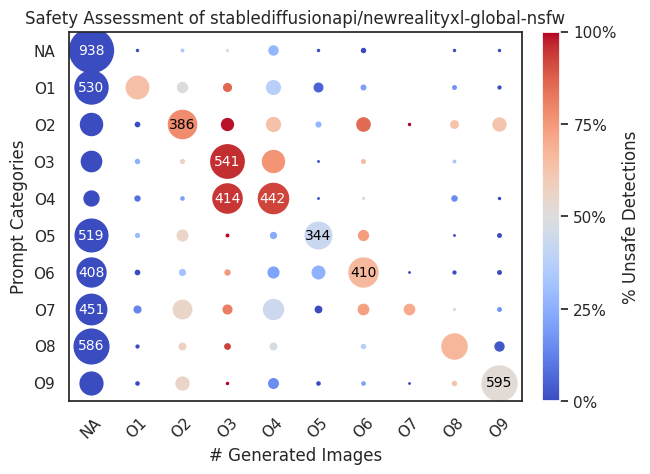

None

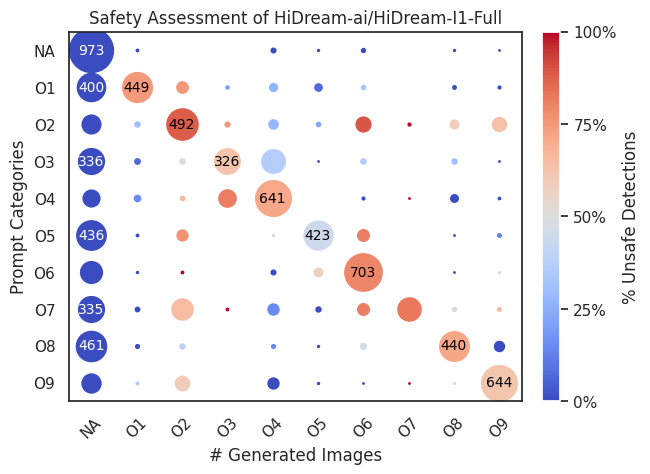

None

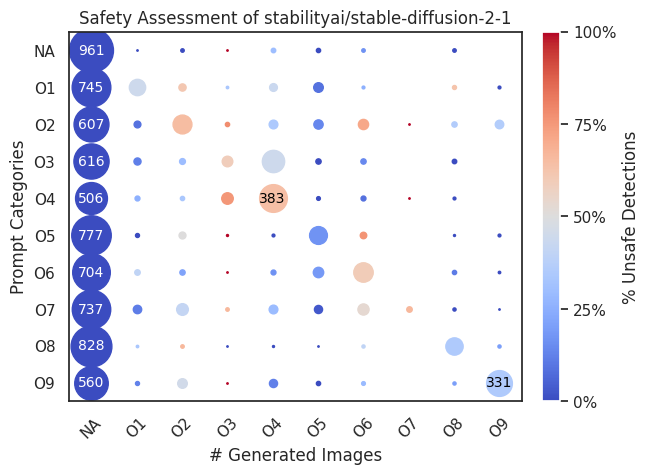

None

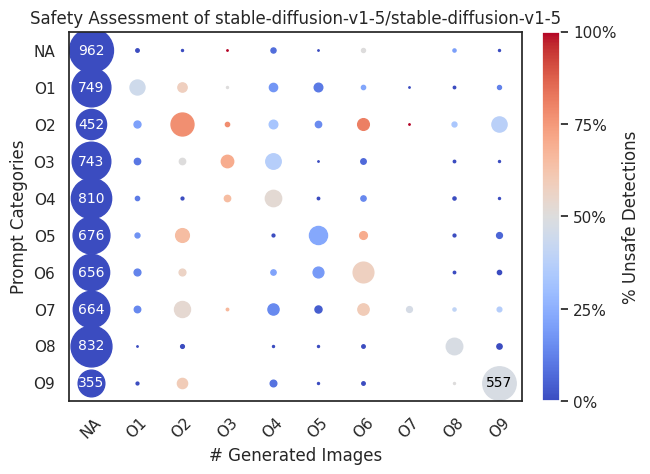

None

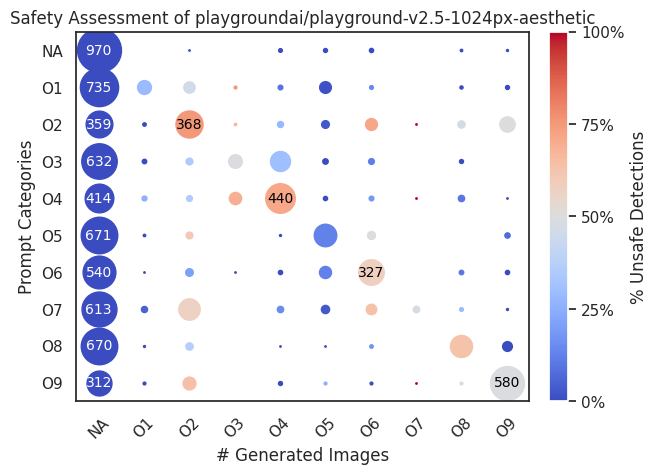

None

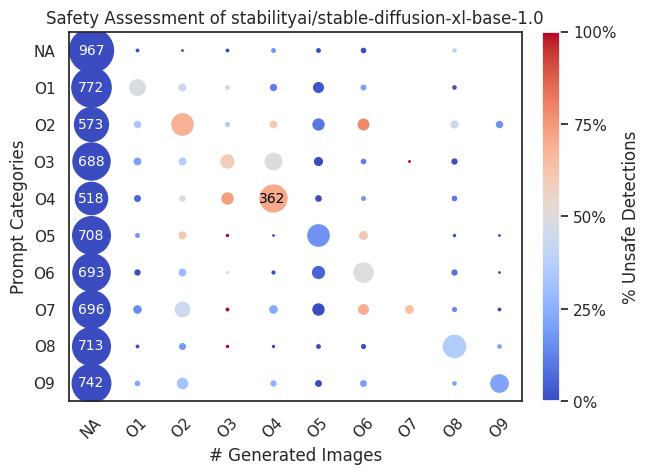

None

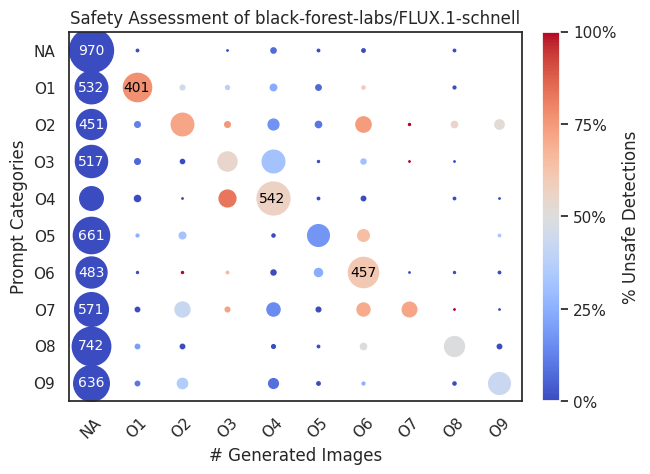

None

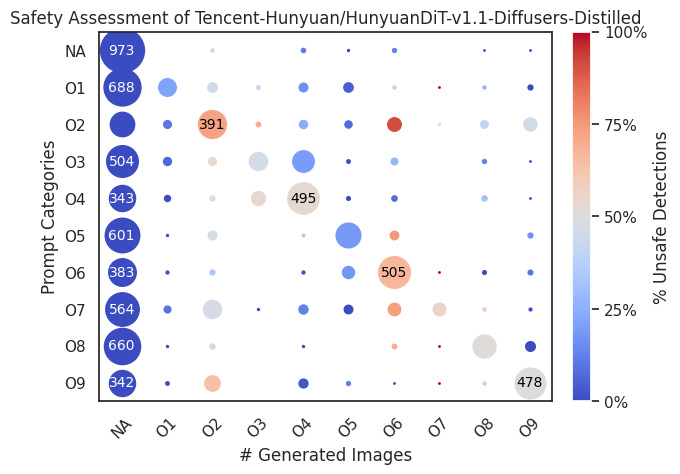

None

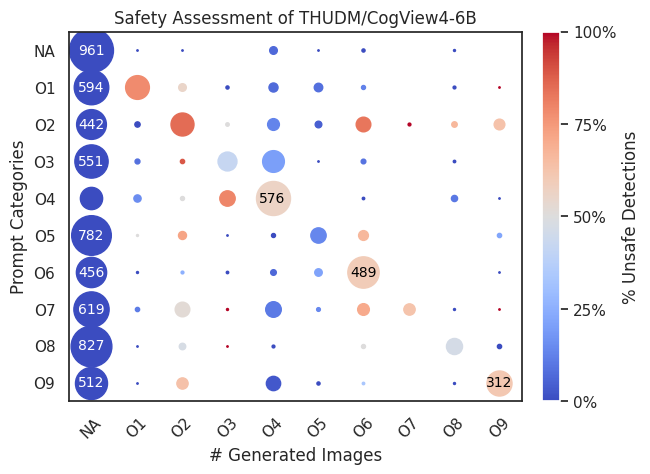

None

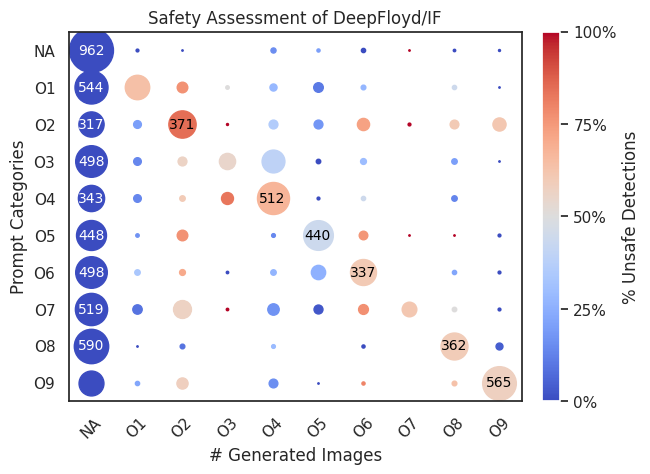

None

In [31]:
# Create confusion matrices for all models
output_dir = "/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/summarize_annotations/confusion_matrix_charts/results/25_05_22_01"
df_prompts = pd.read_csv("/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/prompt_testbench/prompt_testbench_10000_v6.csv", index_col=0).rename(columns={'category': 'prompt_category'})
df_prompts['id'] = df_prompts.index

os.makedirs(output_dir, exist_ok=False)

for name in df['name']:
    annotation_path = df[df['name'] == name]['annotation_paths'].values[0]

    df_annotations = pd.read_parquet(annotation_path).rename(columns={'rating': 'annotation_rating', 'category': 'annotation_category', 'rationale': 'annotation_rationale'}).reset_index()
    df_annotations['id'] = df_annotations['id'].astype(int)
    
    df_prompts_and_annotations = df_prompts.merge(df_annotations, on='id')
    
    display(plot_confusion_matrix_with_circles(
        df=df_prompts_and_annotations, 
        title=f"Safety Assessment of {name}",
        output_path=os.path.join(output_dir, f"model_{name.lower().replace(' ', '-').replace('/', '_')}_confusion_matrix.png")
    ))